Text(0.5, 1.0, 'Test')

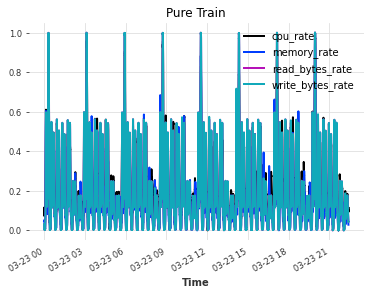

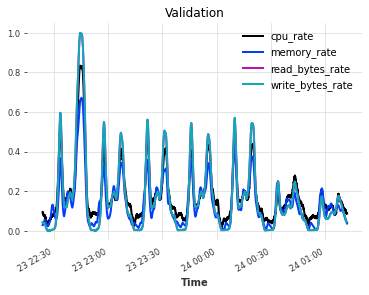

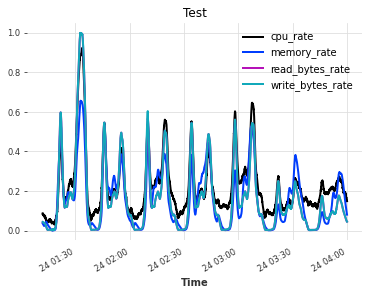

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"


import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
np.random.seed(seed)

import sys
sys.path.append("/home/jupyter-babakesistani/adaptive-monitoring-nn/")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    BlockRNNModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt
import tsaug
import ray
from ray import tune

from matplotlib.pyplot import figure

dl =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/cpu_memory_disk_23_march.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    augment=False, resample_freq="1s", shift_df_datetime="2022-03-23 00:00:00")
scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_train = 8*scaled_one_week
idx_val = 9*scaled_one_week
train = dl.series_scaled[:idx_train]
val = dl.series_scaled[idx_train:idx_val]
test = dl.series_scaled[idx_val:-1]
    
train.plot()
plt.title("Pure Train")

val.plot(new_plot=True)
plt.title("Validation")

test.plot(new_plot=True)
plt.title("Test")

In [2]:
def day_of_week(idxs):
    days = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) // (24*60)) % 7
    encoders = []
    for day in days:
        if day == 0:
            encoders.append(1)
        elif day == 1 or day == 2 or day == 3 or day == 4: 
            encoders.append(2)
        elif day == 5 or day == 6:
            encoders.append(3)
    return encoders

def minute_of_day(idxs):    
    minute_of_day = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) % (24*60))
    return minute_of_day


Text(0.5, 1.0, 'Validation')

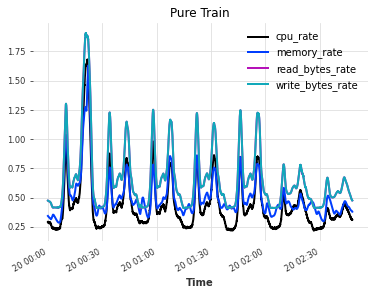

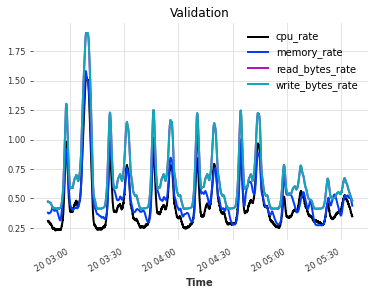

In [3]:
from darts import TimeSeries

dl_retrain =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/23_may_shifted.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    augment=False, resample_freq="1s", shift_df_datetime="2022-04-20 00:00:00")
retrain_df = dl_retrain.darts_df
retrain_series = TimeSeries.from_dataframe(retrain_df, dl_retrain.time_col, dl_retrain.target_cols)
retrain_series = dl.scaler.transform(retrain_series)

scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_train = 1*scaled_one_week
idx_val = 2*scaled_one_week
train = retrain_series[:idx_train]
val = retrain_series[idx_train:idx_val]

    
train.plot()
plt.title("Pure Train")

val.plot(new_plot=True)
plt.title("Validation")

# test.plot(new_plot=True)
# plt.title("Test")

In [4]:
model = BlockRNNModel.load_from_checkpoint("LSTM_23march_300_600",work_dir="../Training/logs/lstm_23march_300_600/", best=True)

[2022-05-24 14:51:50,389] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_82.pth.tar
[2022-05-24 14:51:50,389] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_82.pth.tar


In [20]:
model.n_epochs = 10
model.fit(train, verbose=True)

[2022-05-24 14:35:49,766] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 9481 samples.
[2022-05-24 14:35:49,766] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 9481 samples.


  0%|          | 0/10 [00:00<?, ?it/s]

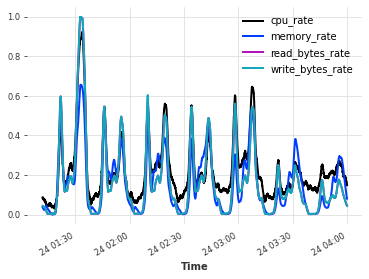

In [5]:
test.plot()

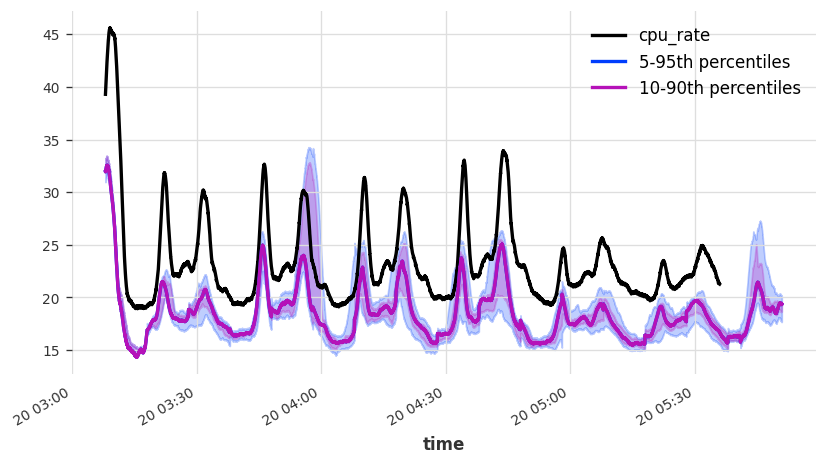

<Figure size 960x480 with 0 Axes>

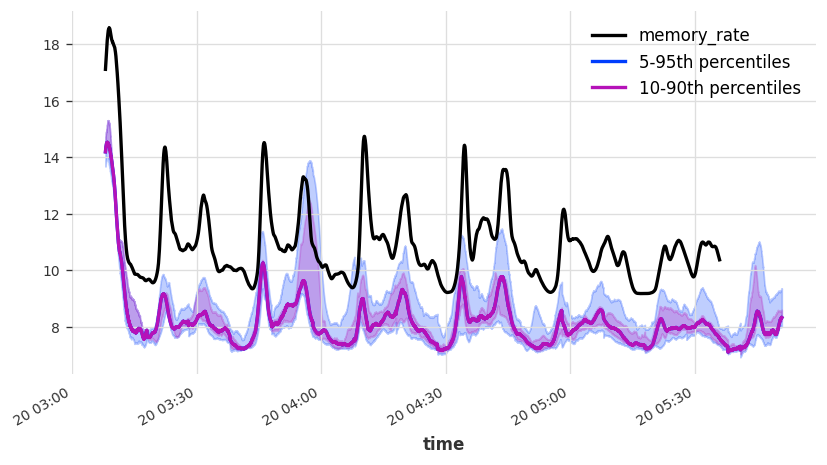

<Figure size 960x480 with 0 Axes>

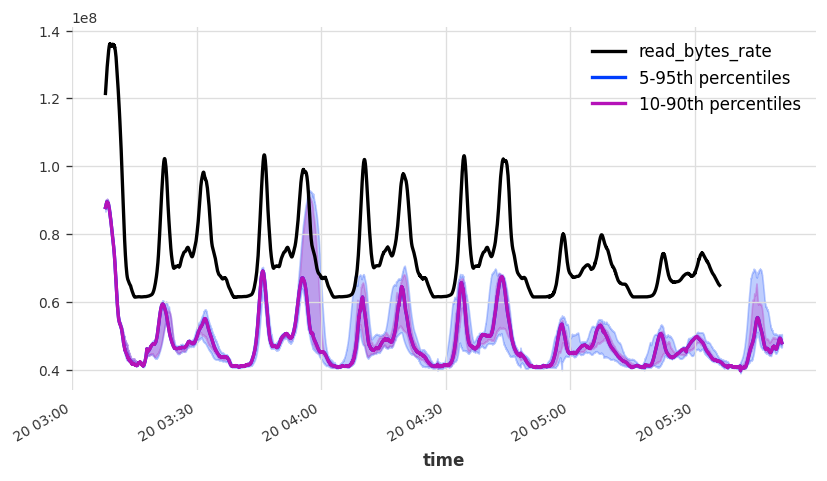

<Figure size 960x480 with 0 Axes>

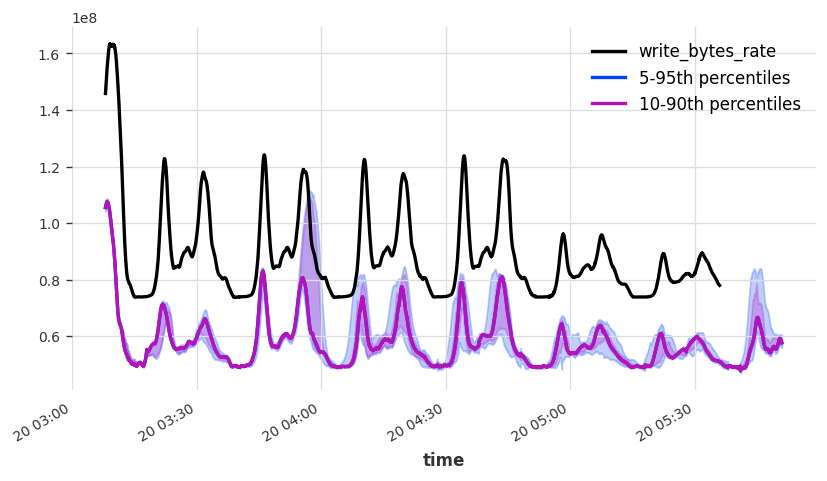

<Figure size 960x480 with 0 Axes>

In [7]:
test = val
cut_off = 1200
pred_len = 10080-300
pred = model.predict(series=test[:cut_off], n=pred_len, num_samples=500)
pred = dl.scaler.inverse_transform(pred)
test_back = dl.scaler.inverse_transform(test)

for i in range(pred.n_components):
    figure(figsize=(8, 4), dpi=120)
    test_back[cut_off:cut_off+pred_len].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.01, high_quantile=0.99, label="5-95th percentiles")
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9,  label="10-90th percentiles")
    figure(figsize=(8, 4), dpi=120)
#     plt.savefig(str(i))
    plt.show()

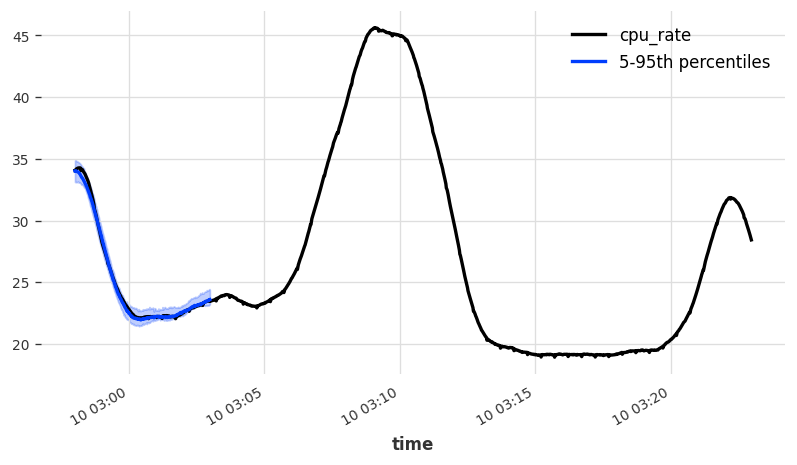

<Figure size 960x480 with 0 Axes>

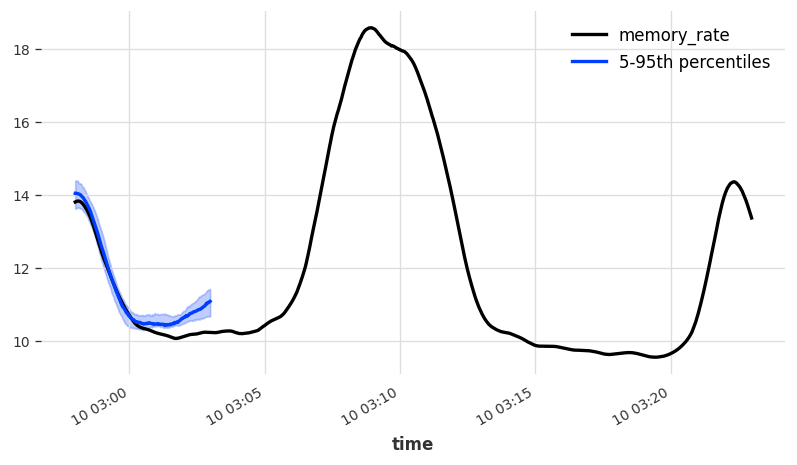

<Figure size 960x480 with 0 Axes>

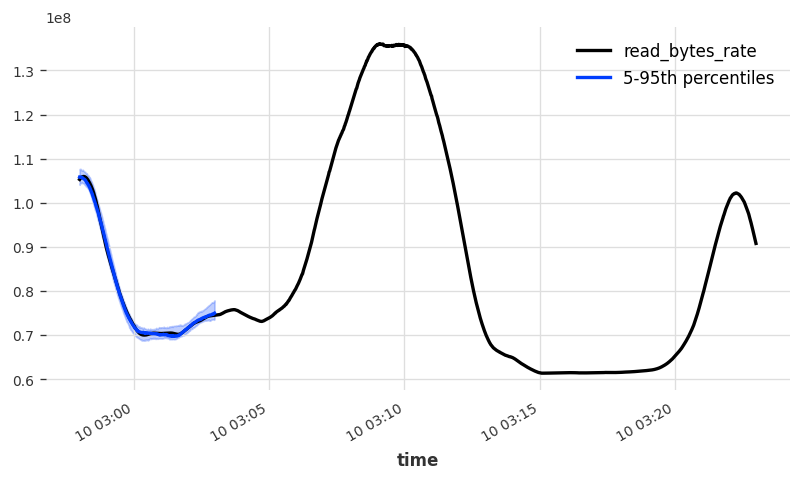

<Figure size 960x480 with 0 Axes>

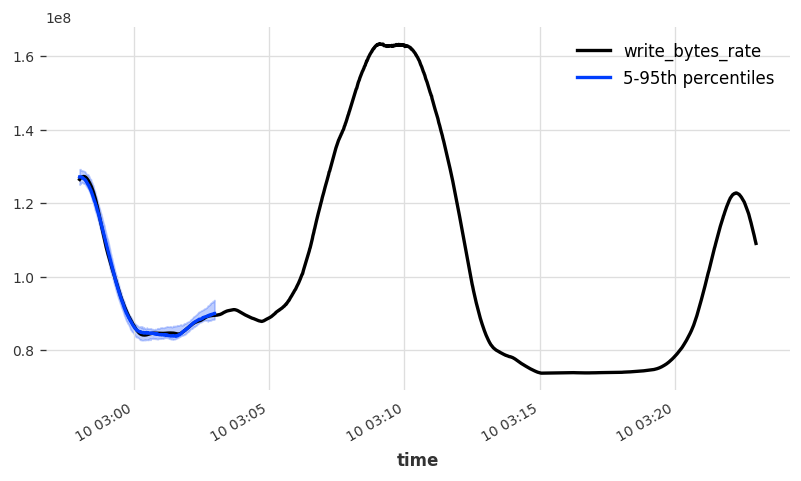

<Figure size 960x480 with 0 Axes>

In [19]:
test = val
cut_off = 600
pred_len = 300
pred = model.predict(series=test[:cut_off], n=pred_len, num_samples=1000)
pred = dl.scaler.inverse_transform(pred)
test_back = dl.scaler.inverse_transform(test)

for i in range(pred.n_components):
    figure(figsize=(8, 4), dpi=120)
    test_back[cut_off:cut_off+pred_len+1200].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.05, high_quantile=0.95, label="5-95th percentiles")
#     pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9,  label="10-90th percentiles")
    figure(figsize=(8, 4), dpi=120)
#     plt.savefig(str(i))
    plt.show()